In [1]:
import time
import numpy as np
import pymc3 as pm
import pandas as pd
from tqdm import tqdm
import os

from numba import jit

import arviz as az
import matplotlib.pyplot as plt

import theano
import theano.tensor as t
from scipy.integrate import solve_ivp

THEANO_FLAGS = 'optimizer=None', 'exception_verbosity=high'
SEED = 1234

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Leitura e tratamento dos arquivos csv gerados

dfB2 = pd.read_csv(r"C:\Users\thais\Downloads\dados_capturados_mistura6\mix1-1_4000novo.csv", sep=';', header=None)
dfB2.columns = ['hours', 'cell_index']
dfB2 = dfB2.replace({',':'.'}, regex=True)
dfB2 = dfB2.astype(float)
#dfS2.info()

In [3]:
#obter somente menores do que 97 horas

dfb2 = dfB2[dfB2['hours'] < 97]
print(len(dfb2))

87


In [4]:
xdados2 = np.array(dfb2['hours'].values)
ydados2 = np.array(dfb2['cell_index'].values)

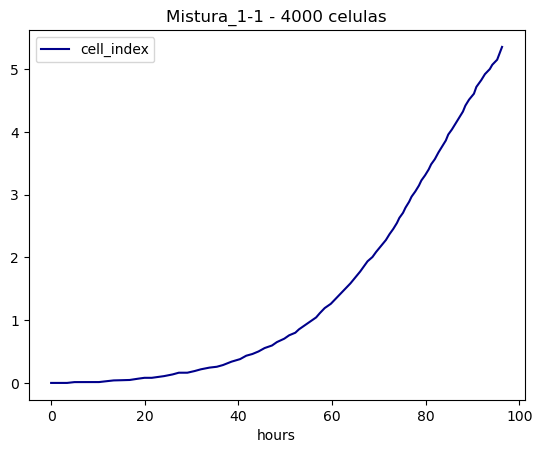

In [5]:
dfb2.plot(x='hours', y='cell_index', c='DarkBlue', title='Mistura_1-1 - 4000 celulas')
plt.show()

In [6]:
# Modelo
def model01(t, X, tauc, taustar, lambda1, lambda2, s0, r0, q0):
    S,R,Q = X
    taus = 13.4731
    taur = 15.0754
    K = 8.2538
    Qn = 0.01
    B = 0.0
    
    dSdt = S/taus * (1 - (S + R)/K) - (S * Q)/tauc + R/taustar
    dRdt = R/taur * (1 - (S + R + B)/K)
    dQdt = (lambda1 * R) - (lambda2 * S) * (Q/ (Qn + Q))
    
    return dSdt, dRdt, dQdt

In [7]:
@theano.compile.ops.as_op(itypes=[t.dvector, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar, t.dscalar], otypes=[t.dvector])
def wrapper1(time_exp2, tauc, taustar, lambda1, lambda2, s0, r0, q0):
    t_span2 = (0.00, time_exp2.max())

    y02 = np.array([s0,r0,q0])    
    y_model2 =  solve_ivp(
        fun = lambda t, y: model01(t, y, tauc=tauc, taustar=taustar, lambda1=lambda1, lambda2=lambda2, s0=s0, r0=r0, q0=q0),
        t_span=t_span2,
        y0=y02,
        t_eval=time_exp2,
        method='LSODA'   
    )
 
    simulated_time2 = y_model2.t
    simulated_ode_solution2 = y_model2.y
    S2,R2,Q2 = simulated_ode_solution2
    sum_vec = sum([S2,R2])
    
    return sum_vec

In [8]:
print('\n*** Performing Bayesian Calibration ***')
print('-- Running Monte Carlo Simulations')

y_conc = ydados2 
observations = y_conc #ydados2
draws = 5000
start_time = time.time()

with pm.Model() as model_smc:

#Priors
    
    tauc = pm.Uniform('tauc', lower=2.0, upper=6.5)
    taustar = pm.Uniform('taustar', lower=13.5, upper=25.0)
    lambda1 = pm.Uniform('lambda1', lower=0.0001, upper=0.1)
    lambda2 = pm.Uniform('lambda2', lower=0.0001, upper=0.1)
    s0 = pm.Uniform('s0', lower=0.001, upper=1.0)
    r0 = pm.Uniform('r0', lower=0.001, upper=1.0)
    q0 = pm.Uniform('q0', lower=0.001, upper=1.0)

    #simulando para 1-1
    fitting_model = pm.Deterministic(
        'model01',
        wrapper1(
            theano.shared(xdados2),
            tauc,
            taustar,
            lambda1,
            lambda2,
            s0,
            r0,
            q0
        )
    )

    likelihood_model = pm.Normal('likelihood_model', mu=fitting_model, sigma=0.001, observed=observations)
    trace_calibration1 = pm.sample_smc(draws, chains=1, parallel=False, cores=1, random_seed = SEED)

duration = time.time() - start_time
print(f'-- Monte Carlo simulations done in {duration / 60:.3f} minutes.')


*** Performing Bayesian Calibration ***
-- Running Monte Carlo Simulations


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.000
Stage:   4 Beta: 0.000
Stage:   5 Beta: 0.000
Stage:   6 Beta: 0.000
Stage:   7 Beta: 0.000
Stage:   8 Beta: 0.001
Stage:   9 Beta: 0.001
Stage:  10 Beta: 0.002
Stage:  11 Beta: 0.004
Stage:  12 Beta: 0.006
Stage:  13 Beta: 0.008
Stage:  14 Beta: 0.011
Stage:  15 Beta: 0.015
Stage:  16 Beta: 0.019
Stage:  17 Beta: 0.026
Stage:  18 Beta: 0.034
Stage:  19 Beta: 0.045
Stage:  20 Beta: 0.064
Stage:  21 Beta: 0.088
Stage:  22 Beta: 0.118
Stage:  23 Beta: 0.162
Stage:  24 Beta: 0.205
Stage:  25 Beta: 0.245
Stage:  26 Beta: 0.293
Stage:  27 Beta: 0.339
Stage:  28 Beta: 0.380
Stage:  29 Beta: 0.434
Stage:  30 Beta: 0.511
Stage:  31 Beta: 0.605
Stage:  32 Beta: 0.708
Stage:  33 Beta: 0.840
Stage:  34 Beta: 1.000


-- Monte Carlo simulations done in 122.470 minutes.


Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


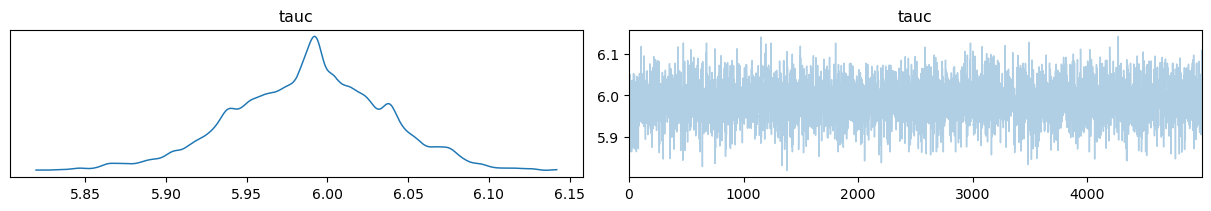

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


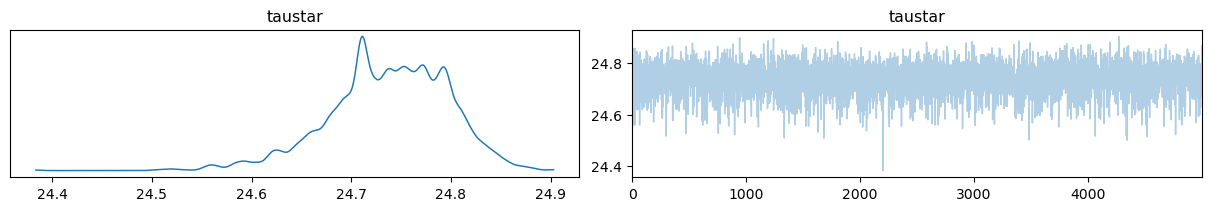

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


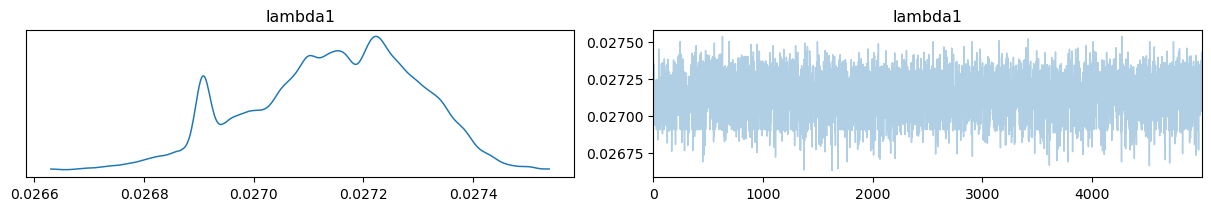

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


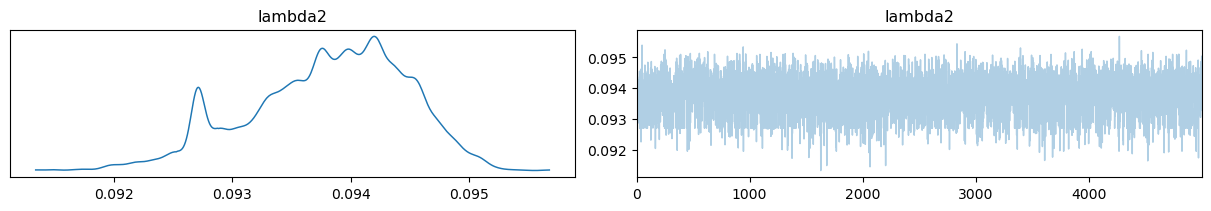

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


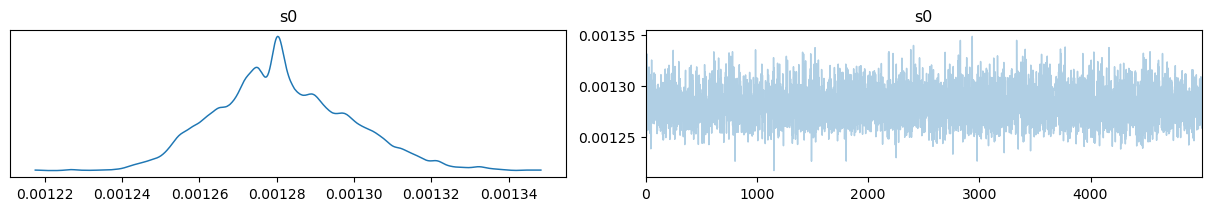

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


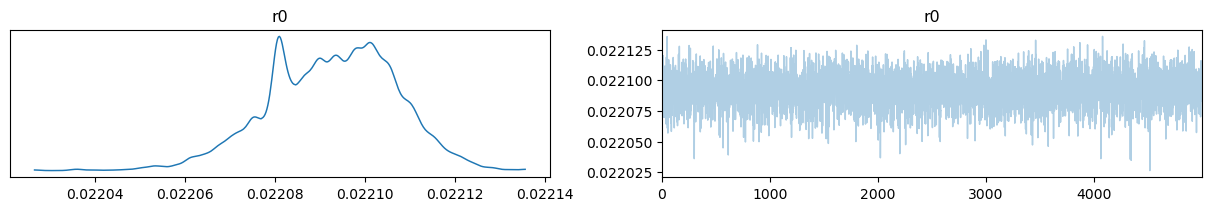

C:\Users\thais\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


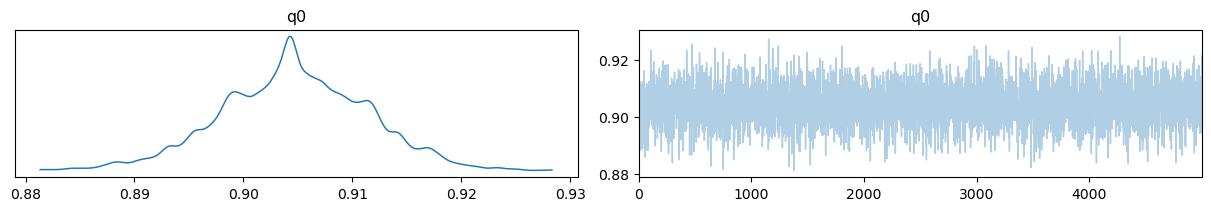

In [9]:
#Plot de cada cadeia

az.plot_trace(trace_calibration1, var_names=('tauc'))
plt.savefig('cadeia-tau_c4000-M4_1-1.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('taustar'))
plt.savefig('cadeia-tau_star4000-M4_1-1.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('lambda1'))
plt.savefig('cadeia-lambda14000-M4_1-1.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('lambda2'))
plt.savefig('cadeia-lambda24000-M4_1-1.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('s0'))
plt.savefig('cadeia-s0-4000-M4_1-1.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('r0'))
plt.savefig('cadeia-r0-4000-M4_1-1.png')
plt.show()

az.plot_trace(trace_calibration1, var_names=('q0'))
plt.savefig('cadeia-q0-4000-M1_1-1.png')
plt.show()


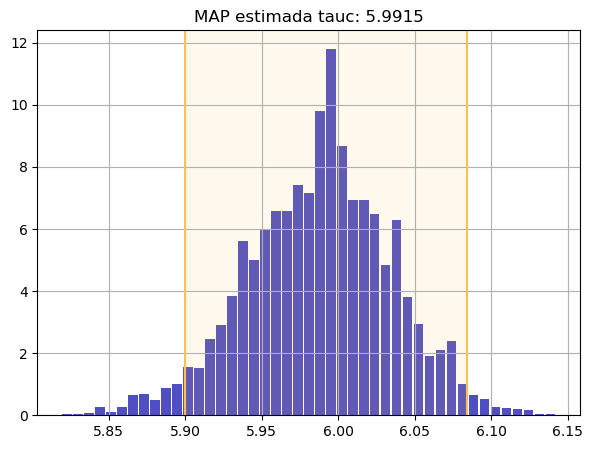

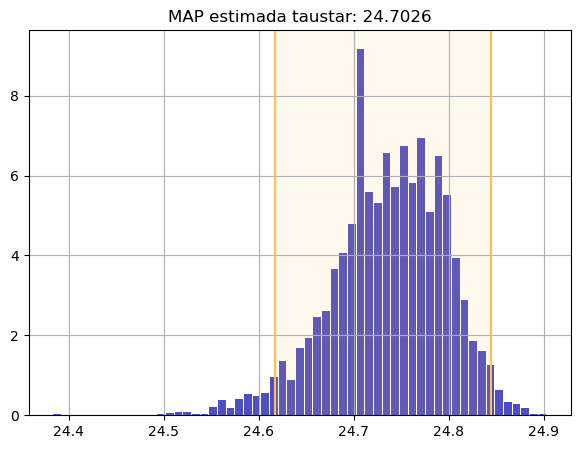

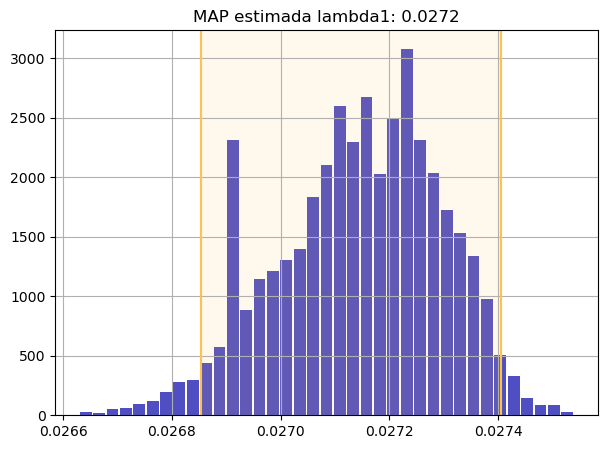

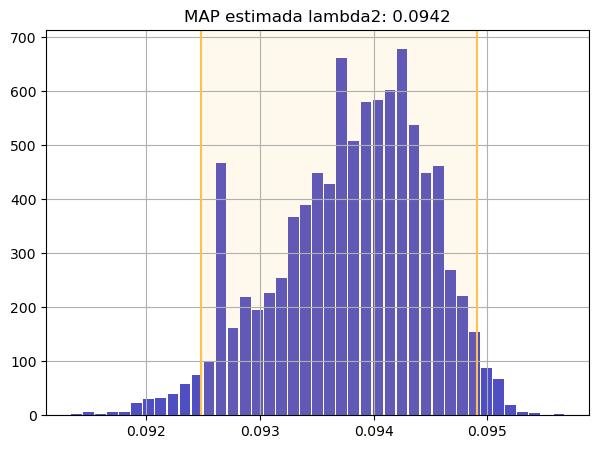

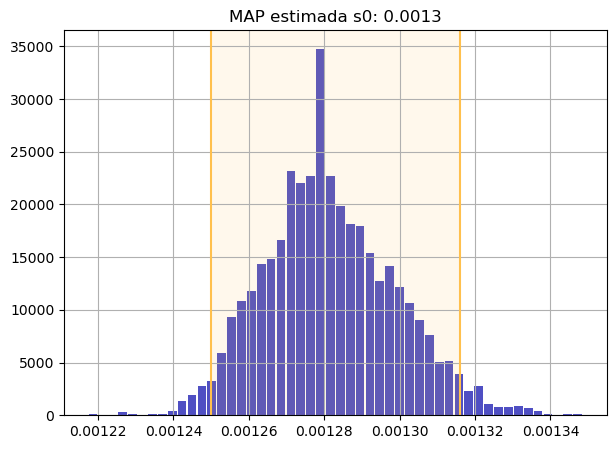

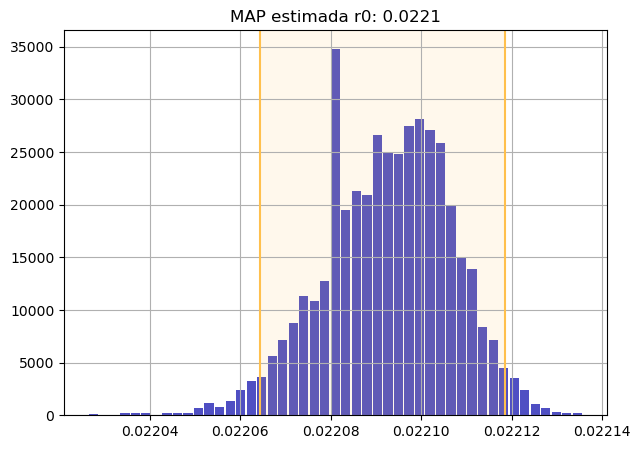

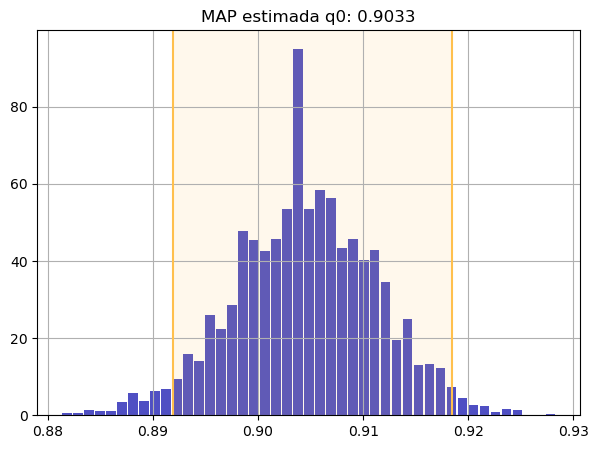

In [10]:
import arviz

fig, ax = plt.subplots(figsize = (7, 5))
#fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)


n, bins, patches = plt.hist(x=trace_calibration1['tauc'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['tauc'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada tauc: {0:.4f}'.format(bins[np.argmax(n)]) )
plt.grid()

plt.savefig('MAP_tauc_temporarias-4000_M4_1-1.png')
plt.show()

fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['taustar'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['taustar'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada taustar: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()

plt.savefig('MAP_taustar_temporarias-4000-M4_1-1.png')
plt.show()


fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['lambda1'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['lambda1'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada lambda1: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()

plt.savefig('MAP_lambda1-4000-M4_1-1.png')
plt.show()


fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['lambda2'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['lambda2'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada lambda2: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()

plt.savefig('MAP_lambda2-4000-M4_1-1.png')
plt.show()

fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['s0'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['s0'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada s0: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()

plt.savefig('MAP_s0-4000_M4_1-1.png')
plt.show()


fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['r0'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['r0'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada r0: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()

plt.savefig('MAP_r0-4000_M4_1-1.png')
plt.show()


fig, ax = plt.subplots(figsize = (7, 5))

n, bins, patches = plt.hist(x=trace_calibration1['q0'], bins='auto', density = True, color='#0504aa', alpha=0.7, rwidth=0.88, label = 'Posterior')

cred_interv = arviz.hdi(trace_calibration1['q0'], hdi_prob = 0.95)
plt.axvline(x=cred_interv[0], color = '#ffc04d')
plt.axvline(x=cred_interv[1], color = '#ffc04d')
plt.axvspan(cred_interv[0], cred_interv[1], facecolor='#ffc04d', alpha=0.1, label = 'Cred. Interv.')
    
plt.title('MAP estimada q0: {0:.4f}'.format(bins[np.argmax(n)]))
plt.grid()

plt.savefig('MAP_q0-4000_M4_1-1.png')
plt.show()

In [11]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration1["model01"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration1["model01"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration1["model01"], 50, axis=0)

In [12]:
y_min[0:87]

print(len(y_min[0:87]))

minimo = np.reshape(y_min[0:87], (87,))

print(len(minimo))

y_max[0:87]

print(len(y_max[0:87]))

maximo = np.reshape(y_max[0:87], (87,))

print(len(maximo))

y_fit[0:87]

print(len(y_fit[0:87]))

fit = np.reshape(y_fit[0:87], (87))

print(len(fit))

87
87
87
87
87
87


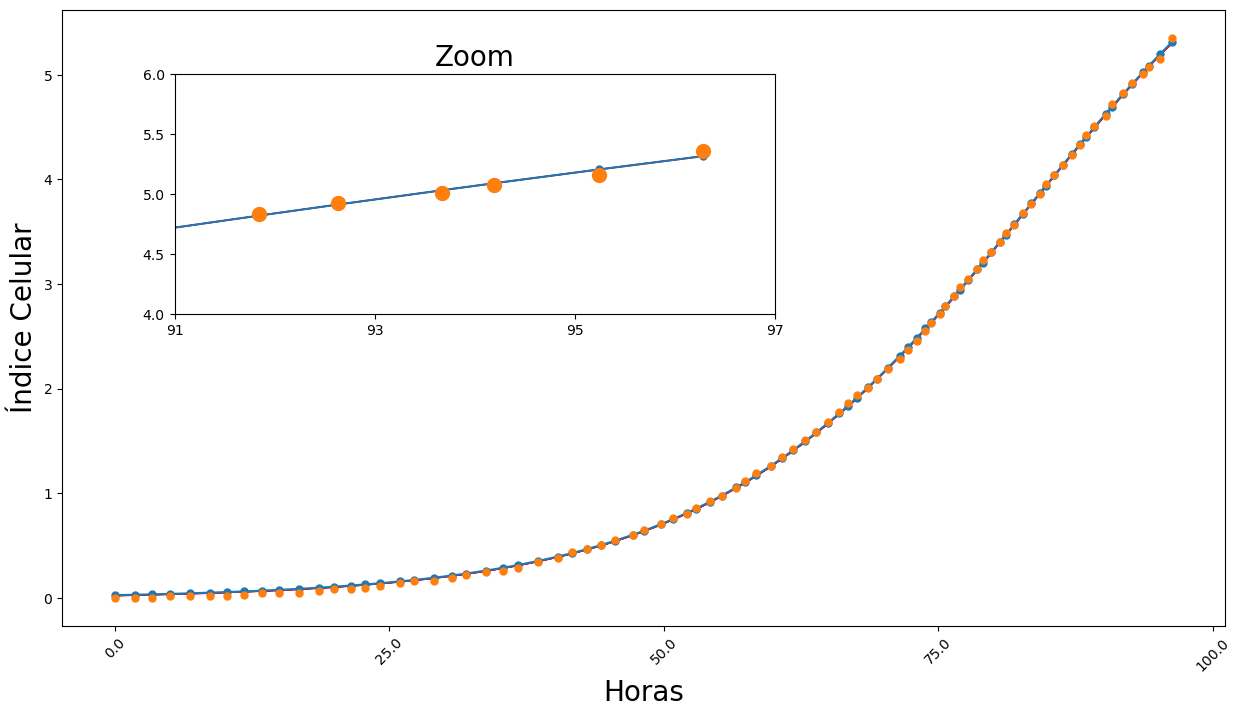

In [13]:
plt.figure(figsize=(15, 8))

# criação do primeiro conjunto de eixos
ax1 = plt.axes() 
ax1.plot(
    xdados2,
    fit,
    label="Simulação",
    marker=".",
    linestyle="-",
    markersize=10,
)
ax1.fill_between(xdados2, minimo, maximo, color="r", alpha=1.0)
ax1.plot(
    xdados2, ydados2, label="Dados células temporárias (2)", marker="o", linestyle="", markersize=5
)
#plt.grid()
t = np.linspace(0, 100, 5)
#ax1.legend(shadow=True)
ax1.set_xticks(t)
ax1.set_xticklabels(t, rotation=45)
ax1.set_xlabel('Horas', fontsize=20)
ax1.set_ylabel('Índice Celular', fontsize=20)

#plt.legend(loc="lower right")

# criação do segundo conjunto de eixos
ax2 = plt.axes([0.2, 0.5, 0.4, 0.3])
ax2.plot(xdados2, fit, marker=".", linestyle="-", markersize=10)
ax2.fill_between(xdados2, minimo, maximo, color="r", alpha=1.0)
ax2.plot(xdados2, ydados2,  marker="o", linestyle="", markersize=10)
ax2.set_xlim(91.0, 97.0)
ax2.set_ylim(4.0, 6.0)
ax2.set_xticks([91.0, 93.0, 95.0, 97.0])
ax2.set_yticks([4.0, 4.5, 5.0, 5.5, 6.0])
#ax2.set_xlabel('Horas', fontsize=15)
#ax2.set_ylabel('Índice Celular', fontsize=15)
ax2.set_title('Zoom', fontsize=20)

plt.savefig('matplotlib_mistura_M4_1-1.png')

plt.show()

In [14]:
#Criterio BIC

soma_logis = sum((fit - ydados2)**2.0)

def bic(sum_qd, qt_params, vec_size):
    
    return (vec_size * np.log(sum_qd / vec_size) + qt_params * np.log(vec_size))

bic_result = bic(soma_logis,7,87)

print(bic_result)

-649.3001053354469
